In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('lending_club_loan_dataset.csv', index_col = 0)
df.head()

,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
id,,,,,,,,,,,,,,
11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [3]:
data = df.copy()
data.drop(columns = ['short_emp', 'last_major_derog_none'], inplace = True)
data['home_ownership'].fillna('None', inplace = True)
data['dti'].fillna(data.dti.median(), inplace = True)
data['term'].replace(' 36 Months', ' 36 months', inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 11454641 to 6625685
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   grade               20000 non-null  object 
 1   annual_inc          20000 non-null  float64
 2   emp_length_num      20000 non-null  int64  
 3   home_ownership      20000 non-null  object 
 4   dti                 20000 non-null  float64
 5   purpose             20000 non-null  object 
 6   term                20000 non-null  object 
 7   last_delinq_none    20000 non-null  int64  
 8   revol_util          20000 non-null  float64
 9   total_rec_late_fee  20000 non-null  float64
 10  od_ratio            20000 non-null  float64
 11  bad_loan            20000 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 2.0+ MB


In [4]:
num_cols = data.select_dtypes(include = 'number').columns.tolist()

cat_cols = data.select_dtypes(include = 'object').columns.tolist()
print(cat_cols)
for col in cat_cols:
    data[col] = data[col].astype('object')

['grade', 'home_ownership', 'purpose', 'term']


In [5]:
# from sklearn.preprocessing import OrdinalEncoder

# odec = OrdinalEncoder()
# odec.fit(data[cat_cols])
# data_odec = odec.transform(data[cat_cols])

# data_odec = pd.DataFrame(data_odec, columns = cat_cols, index = data.index)

# data_ = pd.concat([data[num_cols], data_odec], axis = 1)
# data_.head()

In [6]:
# to leave categorical as categorical
data_ = data.copy()
for col in cat_cols:
    data_[col] = data[col].astype('category')
data_.head()

,grade,annual_inc,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
id,,,,,,,,,,,,
11454641,A,100000.0,1,RENT,26.27,credit_card,36 months,1,43.2,0.0,0.160624,0
9604874,A,83000.0,4,OWN,5.39,credit_card,36 months,0,21.5,0.0,0.810777,0
9684700,D,78000.0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,46.3,0.0,0.035147,1
9695736,D,37536.0,6,MORTGAGE,12.28,medical,60 months,0,10.7,0.0,0.534887,1
9795013,D,65000.0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,15.2,0.0,0.166500,0


In [7]:
from sklearn.model_selection import train_test_split
X = data_.drop(columns = 'bad_loan')
Y = data_['bad_loan']
x_, x_test, y_, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size = 0.05555, random_state = 0)
print("x_train shape: {0}, x_val shape: {1}, x_test shape: {2}".format(x_train.shape, x_val.shape, x_test.shape))

x_train shape: (17000, 11), x_val shape: (1000, 11), x_test shape: (2000, 11)


In [8]:
y_train.value_counts(normalize = True)

bad_loan
0    0.802118
1    0.197882
Name: proportion, dtype: float64

In [9]:
x_train.shape

(17000, 11)

In [10]:
import xgboost
from sklearn.metrics import f1_score
xgb_model = xgboost.XGBClassifier(tree_method = 'hist',
                                  n_estimators = 100,colsample_bytree = 0.5,
                                  eval_metric = f1_score,
                                  enable_categorical = True,
                                  objective = 'binary:logistic', 
                                  random_state = 0,max_depth=5,scale_pos_weight=5)
xgb_model.fit(x_train, y_train)

pred_train = xgb_model.predict(x_train)
pred_val = xgb_model.predict(x_val)

print("Validation F1_score:", f1_score(y_val, pred_val))
print("Train F1_score:", f1_score(y_train, pred_train))

Validation F1_score: 0.4258064516129032
Train F1_score: 0.5645083470037633


In [11]:
pred_test = xgb_model.predict(x_test)

print("Test F1_score:", f1_score(y_test, pred_test))

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_test)

Test F1_score: 0.40934730056406116


0.6261201576597157

In [12]:
imp=pd.DataFrame({"Columns":x_train.columns,"importance":xgb_model.feature_importances_}).sort_values("importance",ascending=False)

In [13]:
imp

,Columns,importance
0,grade,0.202487
6,term,0.185399
9,total_rec_late_fee,0.100586
1,annual_inc,0.081979
4,dti,0.076750
3,home_ownership,0.066467
5,purpose,0.065073
8,revol_util,0.063204
2,emp_length_num,0.056388
10,od_ratio,0.055958


In [14]:
data_[num_cols].corr()

,annual_inc,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
annual_inc,1.000000,0.118024,-0.229507,-0.080378,0.016951,0.014713,-0.004953,-0.092402
emp_length_num,0.118024,1.000000,0.009360,-0.053371,0.027390,-0.012382,0.004446,-0.041420
dti,-0.229507,0.009360,1.000000,0.030328,0.098564,0.011029,0.005478,0.141371
last_delinq_none,-0.080378,-0.053371,0.030328,1.000000,0.013373,-0.011000,-0.001996,0.021494
revol_util,0.016951,0.027390,0.098564,0.013373,1.000000,0.008435,-0.008228,0.053682
total_rec_late_fee,0.014713,-0.012382,0.011029,-0.011000,0.008435,1.000000,-0.002354,0.130233
od_ratio,-0.004953,0.004446,0.005478,-0.001996,-0.008228,-0.002354,1.000000,0.000403
bad_loan,-0.092402,-0.041420,0.141371,0.021494,0.053682,0.130233,0.000403,1.000000


In [15]:
data_.head()

,grade,annual_inc,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
id,,,,,,,,,,,,
11454641,A,100000.0,1,RENT,26.27,credit_card,36 months,1,43.2,0.0,0.160624,0
9604874,A,83000.0,4,OWN,5.39,credit_card,36 months,0,21.5,0.0,0.810777,0
9684700,D,78000.0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,46.3,0.0,0.035147,1
9695736,D,37536.0,6,MORTGAGE,12.28,medical,60 months,0,10.7,0.0,0.534887,1
9795013,D,65000.0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,15.2,0.0,0.166500,0


In [16]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
encode_cols = ['home_ownership', 'purpose', 'term', 'grade']
one_hot_encoded = ohe.fit_transform(data_[encode_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns = ohe.get_feature_names_out(encode_cols), index = data_.index)

data_encoded = pd.concat([data_, one_hot_df], axis = 1)
data_encoded.drop(encode_cols, axis = 1, inplace= True)
data_encoded.head()

,annual_inc,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan,home_ownership_MORTGAGE,home_ownership_None,...,purpose_wedding,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
id,,,,,,,,,,,,,,,,,,,,,
11454641,100000.0,1,26.27,1,43.2,0.0,0.160624,0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9604874,83000.0,4,5.39,0,21.5,0.0,0.810777,0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9684700,78000.0,11,18.45,1,46.3,0.0,0.035147,1,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9695736,37536.0,6,12.28,0,10.7,0.0,0.534887,1,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9795013,65000.0,11,11.26,0,15.2,0.0,0.166500,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
X = data_encoded.drop(columns = 'bad_loan')
Y = data_encoded['bad_loan']
x_, x_test, y_, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size = 0.05555, random_state = 0)

## SELECT KBEST

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

The max F1 score on the validation set is 0.44375, which occurs when number of features is 23.


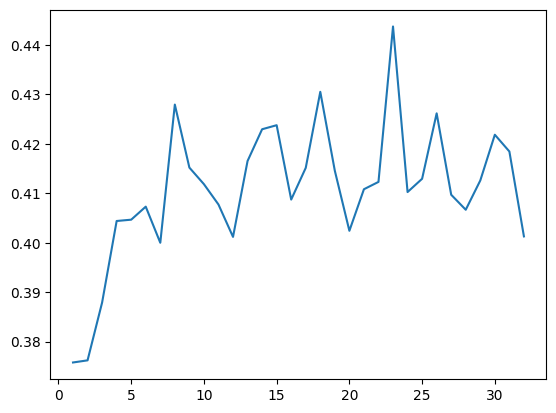

In [19]:
f1_scores = []
m = len(x_train.columns)
l = np.arange(1, m+1)
for i in l:
    test = SelectKBest(score_func = chi2, k = i)
    fit = test.fit(x_, y_)
    kbest = fit.get_feature_names_out()
    
    #to extract only the relevant features from the datasets
    x_train_best, x_val_best, x_test_best = [x[kbest] for x in [x_train, x_val, x_test]]
    
    xgb_model = xgboost.XGBClassifier(tree_method = 'hist', enable_categorical = True, eval_metric = f1_score, 
                                      objective = 'binary:logistic', n_estimators = 100, 
                                      random_state = 0, colsample_bytree = 0.5, max_depth = 5, scale_pos_weight = 5)
    xgb_model.fit(x_train_best, y_train)

    pred_val = xgb_model.predict(x_val_best)
    
    f1_scores.append(f1_score(y_val, pred_val))

max_score = max(f1_scores)
best_num = l[np.argmax(f1_scores)]
print('The max F1 score on the validation set is {}, which occurs when number of features is {}.'.format(max_score, best_num))
plt.plot(l, f1_scores);

In [20]:
# using the same model with the recommended number of features on the test set
test = SelectKBest(score_func = chi2, k = best_num)
fit = test.fit(x_, y_)
kbest = fit.get_feature_names_out()

#to extract only the relevant features from the datasets
x_train_best, x_val_best, x_test_best = [x[kbest] for x in [x_train, x_val, x_test]]

xgb_model = xgboost.XGBClassifier(tree_method = 'hist', enable_categorical = True, eval_metric = f1_score, 
                                  objective = 'binary:logistic', n_estimators = 100, 
                                  random_state = 0, colsample_bytree = 0.5, max_depth = 5, scale_pos_weight = 5)
xgb_model.fit(x_train_best, y_train)

pred_test = xgb_model.predict(x_test_best)

print("The F1-score of this model on test set is :", f1_score(pred_test, y_test))

The F1-score of this model on test set is : 0.4188649080735412


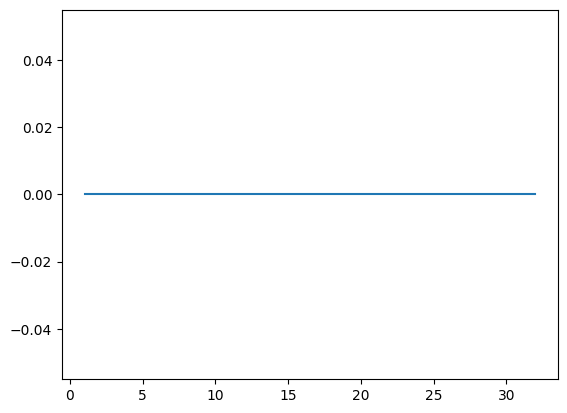

In [21]:
from sklearn.linear_model import LogisticRegression

f1_scores = []
l = np.arange(1, m+1)
for i in l:
    test = SelectKBest(score_func = chi2, k = i)
    fit = test.fit(x_, y_)

    kbest = fit.get_feature_names_out()

    #to extract only the relevant features from the datasets
    x_train_best, x_val_best, x_test_best = [x[kbest] for x in [x_train, x_val, x_test]]
    lr_model = LogisticRegression()
    lr_model.fit(x_train_best, y_train)

    pred_val = lr_model.predict(x_val_best)
    
    f1_scores.append(f1_score(y_val, pred_val))
    
plt.plot(l, f1_scores)

# Select from Model feature selection

In [22]:
from sklearn.feature_selection import SelectFromModel

xgb_model2 = xgboost.XGBClassifier()
mod = SelectFromModel(xgb_model2, prefit = False, max_features = 10)
mod.fit(x_train, y_train)
best_features = list(mod.get_feature_names_out())
print(best_features)

x_train_best, x_val_best, x_test_best = [x[best_features] for x in [x_train, x_val, x_test]]
xgb_model2.fit(x_train_best, y_train)
pred_val = xgb_model2.predict(x_val_best)

print(f1_score(pred_val, y_val))

['total_rec_late_fee', 'purpose_small_business', 'term_ 36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F']
0.043668122270742356
